In [20]:
# Import the standard libraries and packages.
import numpy as np
import pandas
import torch
from zipfile import ZipFile
import scipy.io
import matplotlib.pyplot as plt
import os
import math

In [2]:
#from LinearRegression import LinearRegression
from FullyConnectedNetwork import FullyConnectedNetwork
from CustomDataset import CustomDataset
from Standardization import Standardization
import DataProcessing as DP
from CollateFunction import collate_fn

In [ ]:
# Download the data
#!wget https://archive.ics.uci.edu/static/public/733/water+quality+prediction-1.zip

In [3]:
_CURRENTDIR = os.path.abspath('')

In [ ]:
# Unzip the datafile
#data_fpath = _CURRENTDIR + '/water+quality+prediction-1.zip'
#with ZipFile(data_fpath) as zobject:
#    zobject.extractall()

In [4]:
datapath = _CURRENTDIR + '/water_dataset.mat'
waterdata = scipy.io.loadmat(datapath)

First, let's take a look at the keys and the data type of their values contained in the dataset. X and Y represent the input features and the output targets respectively. Training set and test set are represented by 'tr' and 'te'. The water data are split into three groups according to the location of the source of the water. 

In [5]:
waterdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_tr', 'X_te', 'Y_tr', 'Y_te', 'location_group', 'features', 'location_ids'])

In [6]:
dict_values_type = {k: type(v) for k, v in waterdata.items()}
dict_values_type

{'__header__': bytes,
 '__version__': str,
 '__globals__': list,
 'X_tr': numpy.ndarray,
 'X_te': numpy.ndarray,
 'Y_tr': numpy.ndarray,
 'Y_te': numpy.ndarray,
 'location_group': numpy.ndarray,
 'features': numpy.ndarray,
 'location_ids': numpy.ndarray}

Let's take a look at the features, location_group, and location_ids. There are 11 features, 3 location groups, and 37 locations.

In [7]:
waterdata['features']

array([[array(['Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Maximum)'],
              dtype='<U100')                                                                                           ,
        array(['pH, water, unfiltered, field, standard units (Maximum)'],
              dtype='<U54')                                              ,
        array(['pH, water, unfiltered, field, standard units (Minimum)'],
              dtype='<U54')                                              ,
        array(['Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Minimum)'],
              dtype='<U100')                                                                                           ,
        array(['Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Mean)'],
              dtype='<U97')                                                                            

In [8]:
waterdata['location_group'].shape

(1, 3)

In [9]:
waterdata['location_ids'].shape

(37, 1)

Now let's see the shape of the input vector and output vector in the training set. It seems there are 423 samples in the training set. Test set has 282 samples.

In [10]:
waterdata['X_tr'].shape, waterdata['Y_tr'].shape

((1, 423), (37, 423))

In [11]:
waterdata['X_te'].shape, waterdata['Y_te'].shape

((1, 282), (37, 282))

In [12]:
waterdata['X_tr'][0][0].shape

(37, 11)

A sample in the training set has a shape of (37, 11) indicating 11 features for each of the 37 locations. Therefore, if we stack the training samples we will get feature vectors of shape (423, 37, 11), which means each location has 423 samples. For this experiment we will consider only a single location's data and try to fit a regression line to predict the output of that location.

In [13]:
location_idx = 1
Xdata = np.stack(waterdata['X_tr'][0])[:, location_idx, :]
Tdata = waterdata['Y_tr'][location_idx].reshape(-1, 1)
Xdata.shape, Tdata.shape

((423, 11), (423, 1))

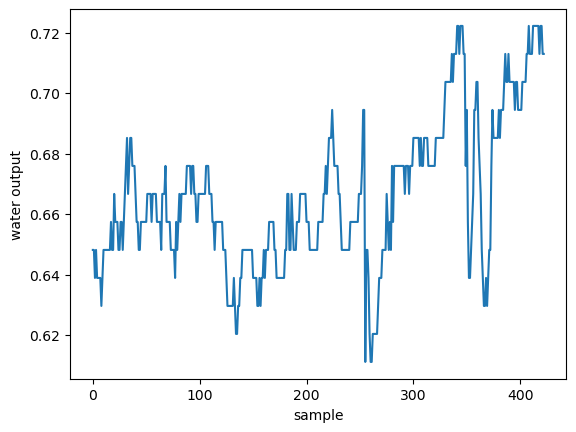

In [14]:
plt.plot(Tdata)
plt.xlabel('sample')
plt.ylabel('water output');

In [15]:
train_data, valid_data = DP.split_data(Xdata, Tdata)

Xtrain, Ttrain = train_data
Xvalid, Tvalid = valid_data

Xtest = np.stack(waterdata['X_te'][0])[:, location_idx, :]
Ttest = waterdata['Y_te'][location_idx].reshape(-1, 1)

st_obj = Standardization(Xtrain, Ttrain)

split_tuples_list = [(Xtrain, Ttrain), (Xvalid, Tvalid), (Xtest, Ttest)]

dataset_list = [CustomDataset(np.hstack((DP.preprocess(*stup, st_obj)))) for stup in split_tuples_list]

batch_size_list = [100, 100, 100]
shuffle_list = [True, False, False]

trainloader, validloader, testloader = (torch.utils.data.DataLoader(dataset, 
                                                                    batch_size = batch_size, 
                                                                    collate_fn = collate_fn, 
                                                                    shuffle = shuffle) 
                                        for dataset, batch_size, shuffle 
                                        in zip(dataset_list, batch_size_list, shuffle_list))

In [16]:
# Size of train, validation, test set.
Xtrain.shape, Xvalid.shape, Xtest.shape

((338, 11), (85, 11), (282, 11))

In [77]:
preds_list = []
evaluation_res_list = []

train_error_list = []
train_error_trace_list = []

valid_error_list = []
valid_error_trace_list = []

in_units = Xtrain.shape[-1] 
out_units = Ttrain.shape[-1]
use_gpu = True

arch_list = [[5, 10], [4, 5, 8], [10, 40, 20], [90, 100]]
lr_list = [0.001, 0.00001, 0.0001, 0.002]
n_epochs_list = [200, 300, 100, 50]

best_vloss = None
states_path = './saved_states/water_quality_model_states.pth'

for n_hidden_units_list, learning_rate, n_epochs in zip(arch_list, lr_list, n_epochs_list):

    print('|', end = ' ')

    lr_model = FullyConnectedNetwork(in_units, n_hidden_units_list, out_units, use_gpu)
    lr_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss, states_path = states_path) 
    best_vloss = lr_model.get_best_validation_loss()
    
    train_error_trace, valid_error_trace = lr_model.get_error_trace()
    train_error = train_error_trace[-1]
    valid_error = valid_error_trace[-1]
    train_error_trace_list.append(train_error_trace)
    train_error_list.append(train_error)
    valid_error_trace_list.append(valid_error_trace)
    valid_error_list.append(valid_error)
    
    Y_pred = lr_model.predict(testloader) #trainloader
    Y_pred = DP.postprocess(t = Y_pred, st_obj = st_obj)[1]
    preds_list.append(Y_pred)
    evaluation_res_list.append(lr_model.evaluate(testloader))

| | | | 

In [78]:
# Show the initial results of the experiments.

pandas.set_option('display.max_colwidth', None)
pandas.DataFrame([arch_list, n_epochs_list, lr_list, train_error_list, valid_error_list, evaluation_res_list], 
                 index = ['Hidden_units', 'Epochs', 'lr', 'Tr-loss', 'Val-loss', 'Test-MSE']).T

,Hidden_units,Epochs,lr,Tr-loss,Val-loss,Test-MSE
0,"[5, 10]",200,0.001,0.139384,1.487791,0.321065
1,"[4, 5, 8]",300,0.00001,1.027444,4.791223,2.112563
2,"[10, 40, 20]",100,0.0001,0.315868,2.486659,0.542666
3,"[90, 100]",50,0.002,0.117858,1.292027,0.311772


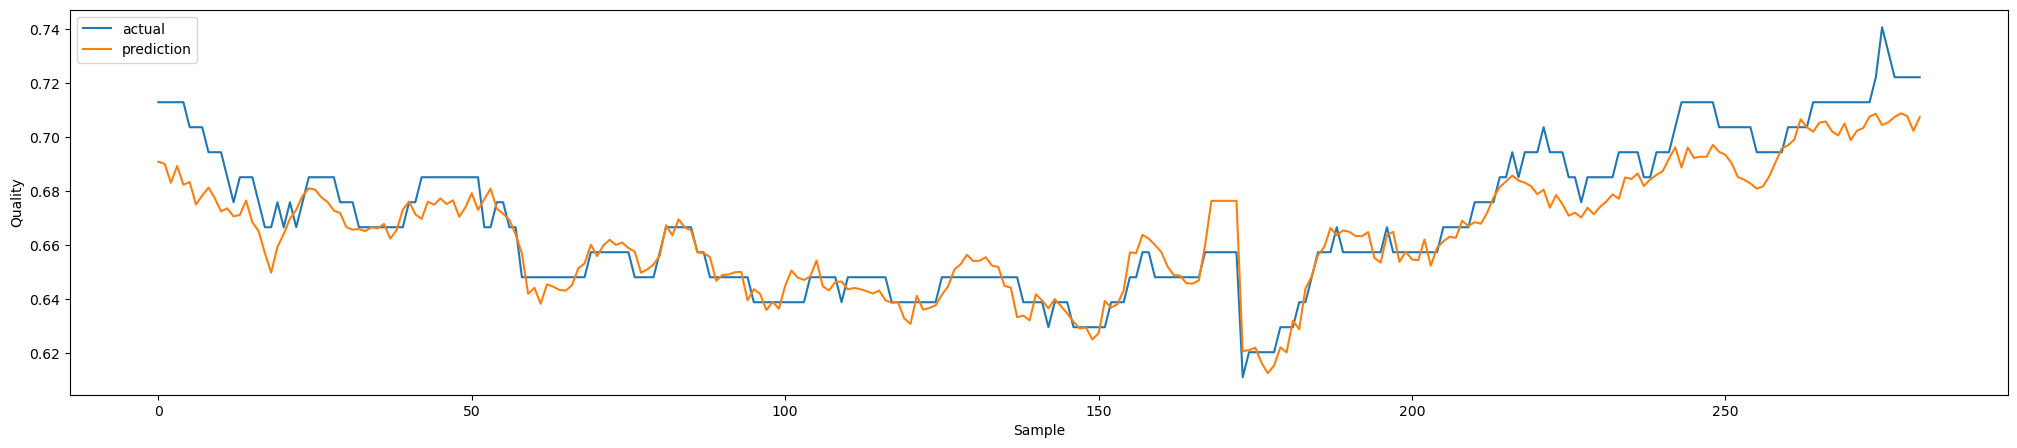

In [79]:
# Latest trained model's result

plt.figure(figsize=(25, 5))
plt.plot(Ttest[:], label='actual')
plt.plot(Y_pred[:], label='prediction')
plt.xlabel('Sample')
plt.ylabel('Quality')
plt.legend();

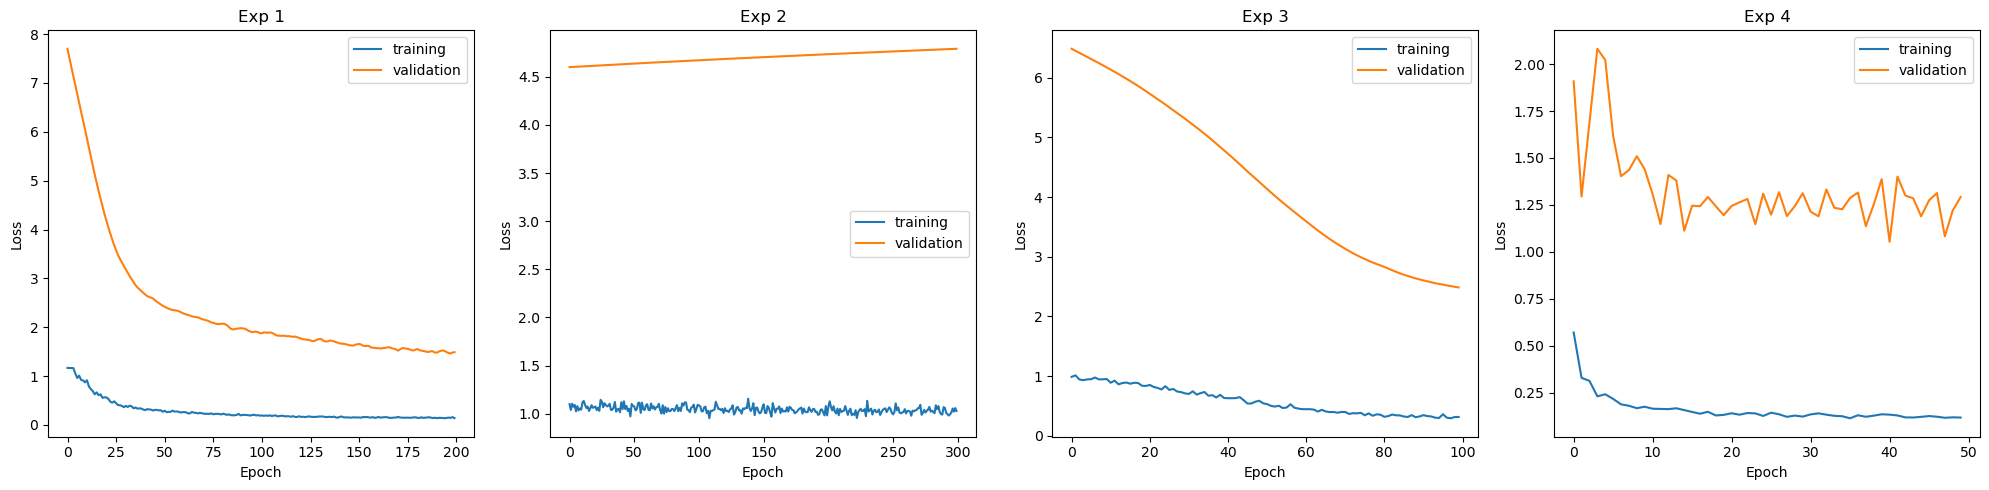

In [80]:
# The loss plots of the experiments.

plt.figure(figsize = (20, 5))
n = len(arch_list)
col = 4 #int(n/4)
row = math.ceil(n/col)
for i in range(n):
    plt.subplot(row, col, i+1)
    plt.plot(train_error_trace_list[i], label = 'training')
    plt.plot(valid_error_trace_list[i], label = 'validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Exp {i+1}')
plt.tight_layout()

In [81]:
# Best trained model's result

trained_model_states_path = states_path #'model_states.pth'
lr_model.nnet.load_state_dict(torch.load(trained_model_states_path)['model_state_dict'])
Y_pred = lr_model.predict(testloader) 
Y_pred = DP.postprocess(t = Y_pred, st_obj = st_obj)[1]
#model.to(DEVICE)

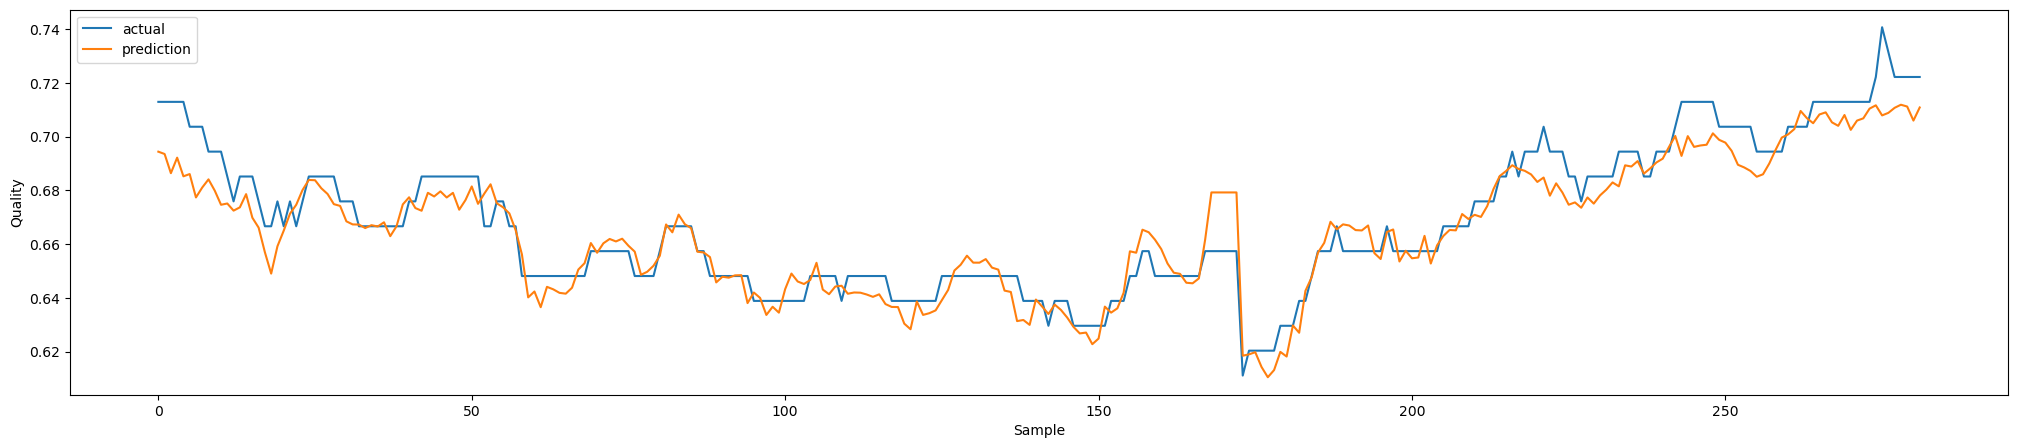

In [82]:
plt.figure(figsize=(25, 5))
plt.plot(Ttest[:], label='actual')
plt.plot(Y_pred[:], label='prediction')
plt.xlabel('Sample')
plt.ylabel('Quality')
plt.legend();

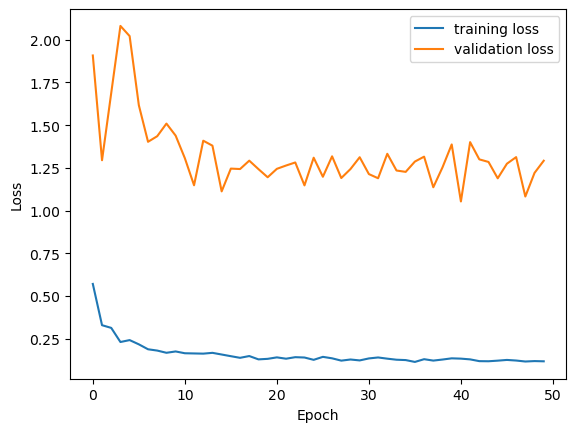

In [83]:
train_error, valid_error = lr_model.get_error_trace()
plt.plot(train_error, label = 'training loss')
plt.plot(valid_error, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [84]:
# Choose the network with better result, change anything needed, and train longer.
# No evaluation method in this script. Add one for regression analysis.

states_path = './saved_states/water_quality_model_states.pth'

checkpoint = torch.load(states_path)
#best_idx = np.argmax(evaluation_res_list)
best_args = checkpoint['model_args']
n_epochs = checkpoint['epoch']
learning_rate = checkpoint['loss']

in_units, n_hidden_units_list, out_units, use_gpu = best_args

learning_rate = 0.01
n_epochs = 15

# Specify a new path for saving the states of this trial.
best_vloss = None
states_path = './saved_states/water_quality_model_states_trial.pth'

lr_model = FullyConnectedNetwork(in_units, n_hidden_units_list, out_units, use_gpu) 

# Now either load the trained model's states and retrain (uncomment the following line)
#lr_model.nnet.load_state_dict(checkpoint['model_state_dict'])

lr_model.train(trainloader, validloader, learning_rate, n_epochs, best_vloss, states_path = states_path)   
best_vloss = lr_model.get_best_validation_loss()
print(f'Best validation loss: {best_vloss:.3f}')

train_error_trace, valid_error_trace = lr_model.get_error_trace()

Y_preds = lr_model.predict(testloader)
Test_mse = lr_model.evaluate(testloader)
print(f'Test Mean Squared Error: {Test_mse:.4f}')

Best validation loss: 1.147
Test Mean Squared Error: 0.3330


In [ ]:
# Add some evaluation metrics and visualization of regression analysis.
# Mean Absolute Error
# Mean Squared Error
# R-Squared Score
# RMSE

## Resume model training from checkpoint

In [30]:
# Load best model architecture and resume training or finetuning the model.

#lr_model_resume = LinearRegression(args)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

states_path = './saved_states/water_quality_model_states_trial.pth'

checkpoint = torch.load(states_path) #('model_states.pth')

lr_model_resume = FullyConnectedNetwork(*checkpoint['model_args'])
optimizer = lr_model_resume.setup_optimizer(learning_rate = 0.001)

lr_model_resume.nnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

lr_model_resume.train(trainloader, validloader, learning_rate, n_epochs, best_vloss, states_path = states_path)